In [1]:
import sys
print(sys.executable)  # should print /usr/bin/python
!{sys.executable} -m pip install -U pip

# install all your needed packages
!{sys.executable} -m pip install pandas face_alignment lpips matplotlib torchmetrics piq

/usr/local/bin/python
  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached face_alignment-1.4.1-py2.py3-none-any.whl.metadata (7.4 kB)
  Using cached lpips-0.1.4-py3-none-any.whl.metadata (10 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached torchmetrics-1.8.2-py3-none-any.whl.metadata (22 kB)
  Using cached piq-0.8.0-py3-none-any.whl.metadata (17 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.16.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached scikit_image-0.25.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached tqdm-4.67.1-py3-none-any.

## Imports

In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import cv2
import numpy as np
import os
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm
from glob import glob
from pathlib import Path
import face_alignment

In [3]:


# Load pretrained landmark model (68 points, 2D)
device = 'cuda' if torch.cuda.is_available() else 'mps'


In [4]:

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, device=device, flip_input=False)


Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


100%|██████████| 85.7M/85.7M [00:07<00:00, 12.2MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip
100%|██████████| 91.9M/91.9M [00:09<00:00, 9.66MB/s]


### New Mask Generator

In [3]:
import cv2
import numpy as np
import torch
import face_alignment

class FANNoseMaskGenerator:
    def __init__(self, device=None):
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, flip_input=False, device=device)
        self.nose_idx = list(range(27, 36))  # 27–35 inclusive

    def detect_nose_landmarks(self, img_rgb):
        lms = self.fa.get_landmarks(img_rgb)
        if lms is None or len(lms) == 0:
            return [], False
        nose_pts = lms[0][self.nose_idx, :2].astype(int).tolist()
        return nose_pts, True

    def create_mask(self, img_rgb, landmarks, dilate_px=35, up_shift=8, right_shift=6):
        """
        1. Build convex-hull mask from nose landmarks.
        2. Dilate isotropically (dilate_px).
        3. Expand slightly upward and right (directional bias).
    
        Args:
            dilate_px  : int  - large dilation radius (~30–40 fills full nostrils)
            up_shift   : int  - pixels to extend mask upward (bridge)
            right_shift: int  - pixels to extend mask rightward (toward nose tip)
        """
        H, W = img_rgb.shape[:2]
        mask = np.zeros((H, W), dtype=np.float32)
        if not landmarks:
            return mask
    
        # ---- base hull mask ----
        pts = np.array(landmarks, dtype=np.int32)
        hull = cv2.convexHull(pts)
        cv2.fillConvexPoly(mask, hull, 1.0)
    
        # ---- large isotropic dilation ----
        if dilate_px > 0:
            k = dilate_px if dilate_px % 2 == 1 else dilate_px + 1
            ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
            mask = cv2.dilate(mask, ker, iterations=1)
    
        # ---- directional expansion (up + right) ----
        m = mask.copy()
        if up_shift > 0:
            roll_up = np.roll(mask, -up_shift, axis=0)
            roll_up[-up_shift:, :] = 0  # zero bottom wrap
            m = np.maximum(m, roll_up)
    
        if right_shift > 0:
            roll_right = np.roll(mask, right_shift, axis=1)
            roll_right[:, :right_shift] = 0  # zero left wrap
            m = np.maximum(m, roll_right)
    
        return np.clip(m, 0, 1).astype(np.float32)

    def visualize(self, img_rgb, mask, landmarks=None):
        overlay = img_rgb.copy()
        if landmarks:
            for p in landmarks:
                cv2.circle(overlay, p, 2, (0,255,0), -1)
        blend = (0.7 * overlay + 0.3 * (mask[...,None]*np.array([255,0,0]))).astype(np.uint8)
        return blend

In [5]:
import os, cv2, numpy as np, warnings, logging

# ---- assume you already defined one of these elsewhere ----
# detector = FANNoseMaskGenerator()         # FAN backend
# detector = MediaPipeNoseDetector()        # MediaPipe backend

def _ensure_dir(p): os.makedirs(p, exist_ok=True)

def _make_preview(img_rgb, mask01, alpha=0.35):
    """Return RGB preview with red mask overlay."""
    overlay = (mask01 * 255).astype(np.uint8)
    vis = img_rgb.copy()
    vis = cv2.addWeighted(vis, 1.0, cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB), alpha, 0)
    return vis

def create_nose_mask_from_image(
    in_path, out_mask_path, out_prev_path, detector,
    dilate_px=35, up_shift=8, right_shift=6, preview_alpha=0.35
):
    # --- load image (RGB) ---
    img_bgr = cv2.imread(in_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise RuntimeError(f"cv2.imread failed: {in_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # --- landmarks ---
    landmarks, ok = detector.detect_nose_landmarks(img_rgb)
    if not ok or len(landmarks) == 0:
        raise Warning("No landmarks were detected.")

    # --- base hull ---
    H, W = img_rgb.shape[:2]
    mask = np.zeros((H, W), dtype=np.float32)
    hull = cv2.convexHull(np.array(landmarks, dtype=np.int32))
    cv2.fillConvexPoly(mask, hull, 1.0)

    # --- isotropic dilation (fills full nose/alar) ---
    if dilate_px > 0:
        k = dilate_px if dilate_px % 2 == 1 else dilate_px + 1
        ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
        mask = cv2.dilate(mask, ker, iterations=1)

    # --- directional expansion: up + right (bridge/tip) ---
    m = mask.copy()
    if up_shift > 0:
        r = np.roll(mask, -up_shift, axis=0); r[-up_shift:, :] = 0
        m = np.maximum(m, r)
    if right_shift > 0:
        r = np.roll(mask,  right_shift, axis=1); r[:, :right_shift] = 0
        m = np.maximum(m, r)

    mask01 = np.clip(m, 0, 1).astype(np.float32)

    # --- save mask (8-bit PNG) ---
    _ensure_dir(os.path.dirname(out_mask_path))
    cv2.imwrite(out_mask_path, (mask01 * 255).astype(np.uint8))

    # --- save preview (JPG) ---
    _ensure_dir(os.path.dirname(out_prev_path))
    preview = _make_preview(img_rgb, mask01, alpha=preview_alpha)
    cv2.imwrite(out_prev_path, cv2.cvtColor(preview, cv2.COLOR_RGB2BGR), [int(cv2.IMWRITE_JPEG_QUALITY), 95])

def batch_create_nose_masks(src_dir, dst_dir, detector, exts=('.jpg','.jpeg','.png'),
                            dilate_px=35, up_shift=8, right_shift=6, preview_alpha=0.35):
    """
    Generate masks + previews for all images in src_dir.
    Masks -> dst_dir; Previews -> dst_dir/_preview
    """
    _ensure_dir(dst_dir)
    prev_dir = os.path.join(dst_dir, "_preview"); _ensure_dir(prev_dir)
    warnings.filterwarnings("error", message="No landmarks were detected.")

    for fname in os.listdir(src_dir):
        if not fname.lower().endswith(exts): 
            continue
        stem, _ = os.path.splitext(fname)
        in_path   = os.path.join(src_dir, fname)
        mask_path = os.path.join(dst_dir, f"{stem}.png")
        prev_path = os.path.join(prev_dir, f"{stem}.jpg")

        if os.path.exists(mask_path) and os.path.exists(prev_path):
            logging.info(f"Skip existing: {fname}")
            continue

        try:
            create_nose_mask_from_image(
                in_path, mask_path, prev_path, detector,
                dilate_px=dilate_px, up_shift=up_shift, right_shift=right_shift,
                preview_alpha=preview_alpha
            )
        except Warning as w:
            logging.warning(f"Skipped (no landmarks): {fname} -> {w}")
        except Exception as e:
            logging.error(f"Error on {fname}: {e}")

# ---- Run for all splits ----
base_dir = "/workspace/data_splits"
splits = ["train", "val", "test"]

detector = FANNoseMaskGenerator()  # or MediaPipeNoseDetector()

for split in splits:
    input_folder = os.path.join(base_dir, split, "input")
    mask_folder  = os.path.join(base_dir, split, "mask_input_new")
    batch_create_nose_masks(
        input_folder, mask_folder, detector,
        dilate_px=35, up_shift=8, right_shift=6, preview_alpha=0.35
    )

/usr/local/lib/python3.12/dist-packages/face_alignment/api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")
/usr/local/lib/python3.12/dist-packages/face_alignment/api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")
/usr/local/lib/python3.12/dist-packages/face_alignment/api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")


### Old Nose Mask Generation

In [44]:
def create_nose_mask(image_path, save_path, log):
    try:
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        preds = fa.get_landmarks(img_rgb)
        if preds is None:
            return False
            
    except Warning as w:  # Catch warnings as exceptions
        return False

    landmarks = preds[0]
    nose_points = landmarks[27:36]  # indexes 27–35 in 0-based Python index

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(nose_points), 255)

    cv2.imwrite(save_path, mask)
    return True

In [45]:
import os
import warnings
import logging

def batch_create_nose_masks(src_dir, dst_dir, create_func, exts=('.jpg','.jpeg','.png')):
    """
    Generate nose masks for all images in src_dir and save in dst_dir.
    Skips files if the mask already exists.
    """
    os.makedirs(dst_dir, exist_ok=True)
    warnings.filterwarnings("error", message="No faces were detected.")

    for file in os.listdir(src_dir):
        if file.lower().endswith(exts):
            in_path  = os.path.join(src_dir, file)
            out_path = os.path.join(dst_dir, file)
            if not os.path.exists(out_path):
                try:
                    create_func(in_path, out_path, logging)
                except Warning as w:
                    logging.warning(f"Skipped {file}: {w}")
                except Exception as e:
                    logging.error(f"Error with {file}: {e}")

base_dir = "/workspace/data_splits"
splits = ["train", "val", "test"]

for split in splits:
    input_folder = os.path.join(base_dir, split, "input")
    mask_folder  = os.path.join(base_dir, split, "mask_input")
    batch_create_nose_masks(input_folder, mask_folder, create_nose_mask)

In [4]:
from pathlib import Path

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def _map_stem_to_name(dir_path: Path):
    """Return {stem: filename} for allowed image files (first match per stem)."""
    m = {}
    for p in dir_path.iterdir():
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            m.setdefault(p.stem, p.name)  # keep first occurrence
    return m

def validate_files(img_dir, mask_dir, target_dir, verbose=True):
    img_dir, mask_dir, target_dir = map(Path, (img_dir, mask_dir, target_dir))

    img_map    = _map_stem_to_name(img_dir)
    mask_map   = _map_stem_to_name(mask_dir)
    target_map = _map_stem_to_name(target_dir)

    img_stems    = set(img_map.keys())
    mask_stems   = set(mask_map.keys())
    target_stems = set(target_map.keys())

    common = sorted(img_stems & mask_stems & target_stems)

    missing_mask   = sorted(img_stems - mask_stems)
    missing_target = sorted(img_stems - target_stems)
    orphan_masks   = sorted(mask_stems - img_stems)
    orphan_targets = sorted(target_stems - img_stems)

    if verbose:
        print(f"[validate] counts: img={len(img_stems)} mask={len(mask_stems)} target={len(target_stems)}")
        print(f"[validate] common triples: {len(common)}")
        if missing_mask:   print(f"[validate] missing masks for {len(missing_mask)} imgs, e.g. {missing_mask[:5]}")
        if missing_target: print(f"[validate] missing targets for {len(missing_target)} imgs, e.g. {missing_target[:5]}")
        if orphan_masks:   print(f"[validate] masks without imgs: {len(orphan_masks)}, e.g. {orphan_masks[:5]}")
        if orphan_targets: print(f"[validate] targets without imgs: {len(orphan_targets)}, e.g. {orphan_targets[:5]}")

    # Build (img_filename, target_filename) using the exact filenames found
    pairs = [(img_map[s], target_map[s]) for s in common]

    if len(pairs) == 0:
        raise ValueError(
            "No valid (img, mask, target) triples found.\n"
            f"Checked:\n  img_dir={img_dir}\n  mask_dir={mask_dir}\n  target_dir={target_dir}\n"
            "See [validate] logs above for mismatches."
        )
    return pairs

In [5]:
import torch
import torch.nn.functional as F

def collate_keep_aspect(batch, multiple=32):
    """
    Batch collate that keeps aspect ratios and preserves metadata (fname, file paths).
    Pads all images/masks/targets in the batch to the max H and W,
    rounded up to the nearest multiple.
    """
    imgs, tgts, masks, orig_hw = [], [], [], []
    fnames, input_files, mask_files, target_files = [], [], [], []

    for b in batch:
        x = b["input"]    # [3,H,W]
        y = b["target"]   # [3,H,W]
        m = b["mask"]     # [1,H,W]
        H, W = x.shape[1:]

        imgs.append(x)
        tgts.append(y)
        masks.append(m)
        orig_hw.append(torch.tensor([H, W], dtype=torch.int32))

        # preserve meta fields
        fnames.append(b.get("fname", ""))
        input_files.append(b.get("input_file", ""))
        mask_files.append(b.get("mask_file", ""))
        target_files.append(b.get("target_file", ""))

    # find max height/width in this batch
    Ht = max(t.shape[1] for t in imgs)
    Wt = max(t.shape[2] for t in imgs)

    # round up to nearest multiple (stride)
    Ht = (Ht + multiple - 1) // multiple * multiple
    Wt = (Wt + multiple - 1) // multiple * multiple

    def pad_to(t, Ht, Wt):
        # pad as (left, right, top, bottom)
        return F.pad(t, (0, Wt - t.shape[2], 0, Ht - t.shape[1]))

    X = torch.stack([pad_to(t, Ht, Wt) for t in imgs])
    Y = torch.stack([pad_to(t, Ht, Wt) for t in tgts])
    M = torch.stack([pad_to(t, Ht, Wt) for t in masks])
    OHW = torch.stack(orig_hw)

    return {
        "input": X,     # [B,3,Ht,Wt]
        "target": Y,    # [B,3,Ht,Wt]
        "mask": M,      # [B,1,Ht,Wt]
        "orig_hw": OHW, # [B,2]
        "fname": fnames,
        "input_file": input_files,
        "mask_file": mask_files,
        "target_file": target_files
    }

In [6]:
from pathlib import Path
from torch.utils.data import Dataset
import torch, cv2
import numpy as np

class NoseFolderDataset(Dataset):
    def __init__(self, img_dir, mask_dir, target_dir, size=256):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.target_dir = Path(target_dir)
        self.file_pairs = validate_files(self.img_dir, self.mask_dir, self.target_dir)   # [(img_name, tgt_name), ...]

    def __len__(self):
        return len(self.file_pairs)

    def _read_rgb(self, path):
        img = cv2.imread(str(path), cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        # (H,W,3) uint8
        return img

    import os, re, cv2, glob, numpy as np

    def _read_mask(self, path):
        """
        Reads a mask robustly even if:
          - extension differs (.png, .jpg, .jpeg)
          - name was sanitized (spaces -> _ etc.)
        Falls back to empty mask if not found.
        """
        # ---- try exact path first ----
        if os.path.exists(path):
            m = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
            if m is not None:
                return (m.astype(np.float32) / 255.0)
    
        # ---- build stem & try alternate extensions ----
        stem = os.path.splitext(os.path.basename(path))[0]
        mask_dir = os.path.dirname(path)
        for ext in (".png", ".jpg", ".jpeg"):
            alt = os.path.join(mask_dir, stem + ext)
            if os.path.exists(alt):
                m = cv2.imread(str(alt), cv2.IMREAD_GRAYSCALE)
                if m is not None:
                    return (m.astype(np.float32) / 255.0)
    
        # ---- try sanitized name ----
        s2 = re.sub(r'[^A-Za-z0-9._-]+', '_', stem)
        s2 = re.sub(r'_+', '_', s2).strip('_')
        for ext in (".png", ".jpg", ".jpeg"):
            alt = os.path.join(mask_dir, s2 + ext)
            if os.path.exists(alt):
                m = cv2.imread(str(alt), cv2.IMREAD_GRAYSCALE)
                if m is not None:
                    return (m.astype(np.float32) / 255.0)
    
        # ---- final fallback: try any matching prefix ----
        hits = glob.glob(os.path.join(mask_dir, stem + ".*"))
        hits = [h for h in hits if os.path.splitext(h)[1].lower() in (".png", ".jpg", ".jpeg")]
        if hits:
            m = cv2.imread(hits[0], cv2.IMREAD_GRAYSCALE)
            if m is not None:
                return (m.astype(np.float32) / 255.0)
    
        # ---- completely missing: return blank mask (same H,W as input image later) ----
        print(f"[WARN] Missing mask for: {path}")
        return np.zeros((512, 512), np.float32)

    def __getitem__(self, idx):
        fname, target_f = self.file_pairs[idx]
        ip, mp, tp = self.img_dir/fname, self.mask_dir/fname, self.target_dir/target_f

        img    = self._read_rgb(ip)     # H,W,3
        target = self._read_rgb(tp)     # H,W,3
        mask   = self._read_mask(mp)    # H,W
        
        if img.shape[:2] != target.shape[:2]:
            # minimal: resize target to img (or vice-versa, pick one consistently)
            target = cv2.resize(target, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_AREA)
        if img.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        H, W = img.shape[:2]
        img_t  = torch.from_numpy(img).permute(2,0,1).float()/255.0
        tgt_t  = torch.from_numpy(target).permute(2,0,1).float()/255.0
        mask_t = torch.from_numpy(mask).unsqueeze(0).float()

        return {
            "input": img_t, "target": tgt_t, "mask": mask_t,
            "orig_h": H, "orig_w": W,
            "input_file": str(ip), "mask_file": str(mp), "target_file": str(tp),
            "fname": os.path.basename(fname)
        }

In [7]:
# --------------------------- Generator (UnE) ----------

import torch
import torch.nn as nn
import torch.nn.functional as F

"""
# ----- tiny mask helpers
def dilate_mask_binary(mask, k=14, iters=2):
    out = mask
    for _ in range(iters):
        out = F.max_pool2d(out, kernel_size=k, stride=1, padding=k//2)
    return out.clamp(0,1)

def feather_mask(mask, k=5):
    return F.avg_pool2d(mask, kernel_size=k, stride=1, padding=k//2).clamp(0,1)

"""

# --------------------------- UNet blocks ---------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm2d(out_ch, affine=True),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm2d(out_ch, affine=True),
            nn.SiLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = ConvBlock(in_ch, out_ch)
    def forward(self, x): return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up   = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv = ConvBlock(in_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        # pad if needed (in case odd dims)
        diffY = skip.size(2) - x.size(2)
        diffX = skip.size(3) - x.size(3)
        if diffY != 0 or diffX != 0:
            x = F.pad(x, (0, diffX, 0, diffY))
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


# --------------------------- UNet Generator (residual) ---------------------------
class UNetNoseGenerator(nn.Module):
    """
    UNet that takes RGB+mask (4ch) and predicts a 3ch residual 'delta'.
    Output = rgb + soft_mask * tanh(raw) * scale
    """
    def __init__(self, in_ch=4, out_ch=3, base=64, depth=5, res_max=1):
        """
        depth=5 -> downsample x2 five times (stride 32). Use collate multiple=32.
        For less memory, set depth=4 (stride 16).
        """
        super().__init__()
        self.out_ch = out_ch
        self.res_max = res_max

        # encoder
        self.inc  = ConvBlock(in_ch, base)                 # H
        self.down1 = Down(base,     base*2)                # H/2
        self.down2 = Down(base*2,   base*4)                # H/4
        self.down3 = Down(base*4,   base*8)                # H/8
        self.down4 = Down(base*8,   base*8)                # H/16
        self.has_down5 = (depth >= 5)
        if self.has_down5:
            self.down5 = Down(base*8, base*8)              # H/32

        # decoder
        if self.has_down5:
            self.up1 = Up(base*8 + base*8, base*8)         # concat with down4
            ch_up_in = base*8 + base*8
        else:
            # if no down5, first up will concatenate down3 and bottleneck at base*8
            ch_up_in = base*8 + base*8  # consistent with next lines

        self.up2 = Up(base*8 + base*8, base*8)             # + down3
        self.up3 = Up(base*8 + base*4, base*4)             # + down2
        self.up4 = Up(base*4 + base*2, base*2)             # + down1
        self.up5 = Up(base*2 + base,   base)               # + inc

        self.outc = nn.Conv2d(base, out_ch, kernel_size=3, padding=1)
        nn.init.zeros_(self.outc.weight)
        nn.init.zeros_(self.outc.bias)

        # learnable residual cap
        self._alpha = nn.Parameter(torch.tensor(0.0))  # sigmoid ~0.5 initially

    def forward(self, inp, return_full=False):
        """
        inp: [B,4,H,W]  (RGB + binary/soft mask in channel 4)
        returns: [B,3,H,W] blended output at original size
        """
        rgb   = inp[:, :3]
        mask1 = inp[:, 3:4]

        # encoder
        x1 = self.inc(inp)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        if self.has_down5:
            x6 = self.down5(x5)
            u1 = self.up1(x6, x5)
        else:
            u1 = self.up2(x5, x4)  # skip one level if depth=4

        # decoder path
        if self.has_down5:
            u2 = self.up2(u1, x4)
        else:
            u2 = u1
        u3 = self.up3(u2, x3)
        u4 = self.up4(u3, x2)
        u5 = self.up5(u4, x1)

        raw   = self.outc(u5)               # [B,3,H,W]
        
        delta = raw
        H, W = rgb.shape[-2:]

        if delta.shape[-2:] != (H, W):
            
            delta = F.interpolate(delta, size=(H, W), mode='bilinear', align_corners=False)
        hard   = mask1
        if hard.shape[-2:] != (H, W):
            hard = F.interpolate(hard, size=(H, W), mode='nearest').clamp(0, 1)

        # soft blend within a feathered mask band
        
        #m_soft = feather_mask(hard, k=9)            # [B,1,H,W]
        m_soft = hard
        m3     = m_soft.repeat(1, 3, 1, 1)
        full_rgb = (rgb + delta)
        out    = rgb + delta * m3
        if return_full:
            return out, full_rgb, m_soft
        return out



In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class VGGPerceptualLoss(nn.Module):
    """
    VGG16 feature L1 loss. Works on inputs in [0,1].
    If mask is given (B,1,H,W), it is downsampled per VGG stage and used
    to weight the feature differences spatially.
    """
    def __init__(self, layers=(3, 8, 15, 22), layer_weights=None):
        super().__init__()
        # relu1_2=3, relu2_2=8, relu3_3=15, relu4_3=22 in torchvision VGG16.features
        self.layers = tuple(layers)
        self.layer_weights = (
            [1.0] * len(self.layers) if layer_weights is None else layer_weights
        )

        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features
        self.vgg = vgg.eval()
        for p in self.vgg.parameters():
            p.requires_grad_(False)

        # register mean/std buffers for ImageNet normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)
        self.register_buffer('mean', mean, persistent=False)
        self.register_buffer('std',  std,  persistent=False)

    def _norm(self, x):
        # x expected in [0,1]
        return (x - self.mean) / self.std

    def forward(self, pred, target, mask=None):
        """
        pred, target: (B,3,H,W) in [0,1]
        mask (optional): (B,1,H,W) with 0..1 weights (e.g., your nose mask)
        """
        x = self._norm(pred)
        y = self._norm(target)

        loss = 0.0
        idx_set = set(self.layers)
        lw_iter = iter(self.layer_weights)

        # run through the VGG and collect selected layers
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            y = layer(y)

            if i in idx_set:
                w = next(lw_iter)
                if mask is None:
                    # plain feature L1
                    loss += w * F.l1_loss(x, y)
                else:
                    # masked feature L1 (downsample mask to feature size)
                    m = F.interpolate(mask, size=x.shape[-2:], mode='bilinear', align_corners=False)
                    num = (m * (x - y).abs()).sum()
                    den = m.sum() + 1e-6
                    loss += w * (num / den)

        return loss

In [23]:
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

import os
from pathlib import Path
import torch
from torchvision.utils import make_grid, save_image

def _pad_to_match(t, target_h, target_w):
    """Pad a tensor (C,H,W) with zeros to match target size."""
    _, h, w = t.shape
    pad_h = target_h - h
    pad_w = target_w - w
    if pad_h == 0 and pad_w == 0:
        return t
    return torch.nn.functional.pad(t, (0, pad_w, 0, pad_h))

    

def _find_index_by_stem(dataset, stem: str):
    
    """Find dataset index by filename stem (ignores extension)."""
    stem = Path(stem).stem  # handle if user passed full name
    for i in range(len(dataset)):
        # dataset.file_pairs[i] = (img_name, tgt_name)
        img_name = dataset.file_pairs[i][0]
        if Path(img_name).stem == stem:
            return i
    return None

from pathlib import Path

def _find_index_by_stem(dataset, stem: str):
    stem = Path(stem).stem
    for i in range(len(dataset)):
        img_name = dataset.file_pairs[i][0]
        if Path(img_name).stem == stem:
            return i
    return None

def _resolve_indices(dataset, extra_ids):
    """
    extra_ids: list of stems/filenames (str) or integer indices.
    Returns: list of valid, unique dataset indices in given order.
    """
    seen = set()
    resolved = []
    for x in (extra_ids or []):
        idx = None
        if isinstance(x, int):
            if 0 <= x < len(dataset):
                idx = x
        else:
            idx = _find_index_by_stem(dataset, str(x))
        if idx is None:
            print(f"[WARN] Extra sample not found: {x}")
            continue
        if idx in seen:
            continue
        seen.add(idx)
        resolved.append(idx)
    return resolved

@torch.no_grad()
def save_vis_grid(
    G, loader, device, out_dir, epoch, n=6,
    extra_names=None,         # <--- NEW: list[str|int] (stems or indices)
    max_extra=None            # <--- NEW: optional cap on how many extras to include
):
    """
    Save a grid with n samples from first batch + optional extra samples.
    Each row: [Input | Prediction | Target]
    - extra_names: list of filename stems (or integer indices) to add as extra rows.
    - max_extra: limit number of extras (None = no cap).
    """
    G.eval()
    os.makedirs(os.path.join(out_dir, "samples"), exist_ok=True)

    # ---- first batch ----
    try:
        batch = next(iter(loader))
    except StopIteration:
        print("[WARN] Loader is empty.")
        return

    rgb    = batch["input"].to(device)
    target = batch["target"].to(device)
    mask   = batch["mask"].to(device)
    pred   = G(torch.cat([rgb, mask], dim=1)).clamp(0, 1)

    tiles = []
    k = min(n, rgb.size(0))
    for i in range(k):
        tiles += [rgb[i], pred[i], target[i]]

    # ---- extras (multiple) ----
    extra_count = 0
    if hasattr(loader, "dataset") and extra_names:
        idxs = _resolve_indices(loader.dataset, extra_names)
        if max_extra is not None:
            idxs = idxs[:max_extra]

        for idx in idxs:
            try:
                sample = loader.dataset[idx]
                rgb_e  = sample["input"].unsqueeze(0).to(device)
                tgt_e  = sample["target"].unsqueeze(0).to(device)
                mask_e = sample["mask"].unsqueeze(0).to(device)
                pred_e = G(torch.cat([rgb_e, mask_e], dim=1)).clamp(0, 1)

                # append as a new row
                tiles += [rgb_e[0], pred_e[0], tgt_e[0]]
                # best-effort name for logging
                try:
                    name = Path(loader.dataset.file_pairs[idx][0]).stem
                except Exception:
                    name = f"idx_{idx}"
                print(f"[INFO] Added extra row: {name}")
                extra_count += 1
            except Exception as e:
                print(f"[WARN] Could not process extra idx={idx}: {e}")
    elif extra_names and not hasattr(loader, "dataset"):
        print("[WARN] Loader has no dataset; cannot resolve extra_names.")

    # ---- pad before grid (handles size mismatches) ----
    H = max(t.shape[1] for t in tiles)
    W = max(t.shape[2] for t in tiles)
    tiles = [_pad_to_match(t, H, W) for t in tiles]

    grid = make_grid(tiles, nrow=3, padding=2)
    out_path = os.path.join(out_dir, "samples", f"ep_{epoch:03d}.png")
    save_image(grid, out_path)
    print(f"[OK] Saved visualization grid → {out_path} (extras added: {extra_count})")

    G.train()

"""
def dilate_mask_binary(mask, k=14, iters=2):
   Binary dilation. mask: (B,1,H,W) in {0,1} float.

    out = mask
    for _ in range(iters):
        out = F.max_pool2d(out, kernel_size=k, stride=1, padding=k//2)
    return out.clamp(0,1)

"""

def erode_mask_binary(mask, k=11, iters=1):
    """Binary erosion via max-pool trick."""
    x = 1.0 - mask
    for _ in range(iters):
        x = F.max_pool2d(x, kernel_size=k, stride=1, padding=k//2)
    return (1.0 - x).clamp(0,1)

"""
def feather_mask(mask, k=5):
   Soft edge (0..1) via avg-pool (feathered band).

    return F.avg_pool2d(mask, kernel_size=k, stride=1, padding=k//2).clamp(0,1)
"""



# ---------- simple PatchGAN (1-channel real/fake map) ----------
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=6, base=64):
        super().__init__()
        c = base
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,   c, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c,     c*2, 4, 2, 1), nn.BatchNorm2d(c*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c*2,   c*4, 4, 2, 1), nn.BatchNorm2d(c*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c*4,   c*8, 4, 2, 1), nn.BatchNorm2d(c*8), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c*8,     1, 4, 1, 1)
        )
    def forward(self, x): return self.net(x)



import os, torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
import piq
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure

# ---------- helpers ----------
def crop_to_mask_bbox(t: torch.Tensor, m: torch.Tensor, thresh: float = 0.05, dilate_px: int = 0):
    """
    t: [B,C,H,W], m: [B,1,H,W] in [0,1]; returns batch of crops stacked.
    We find a tight bbox of (m>thresh). Optionally dilate bbox by 'dilate_px'.
    If mask is empty, fall back to full image for that item.
    """
    B, _, H, W = t.shape
    crops = []
    for b in range(B):
        mb = m[b, 0]
        yy, xx = (mb > thresh).nonzero(as_tuple=True)
        if yy.numel() == 0:
            crops.append(t[b:b+1])
            continue
        y0, y1 = yy.min().item(), yy.max().item() + 1
        x0, x1 = xx.min().item(), xx.max().item() + 1
        if dilate_px > 0:
            y0 = max(0, y0 - dilate_px); x0 = max(0, x0 - dilate_px)
            y1 = min(H, y1 + dilate_px); x1 = min(W, x1 + dilate_px)
        crops.append(t[b:b+1, :, y0:y1, x0:x1])
    return torch.cat(crops, dim=0)


@torch.no_grad()
def validate_epoch(
    G, loader, device, ssim_metric,
    epoch: int = 0,
    save_debug: bool = True,
    show_debug: bool = True,
    perceptual_fn=None,          # <- pass your make_perceptual_fn(...) result here
):
    """
    Returns:
        mean_l1_mask, mean_ssim_global, mean_ssim_mask, mean_lpips
    Notes:
        - LPIPS is computed via the provided perceptual_fn (masked + ROI).
        - If perceptual_fn is None, LPIPS is reported as 0.0.
    """
    G.eval()
    tot_l1m = tot_ssim_global = tot_ssim_mask = tot_lpips = 0.0
    n = 0
    debug_done = False

    for batch in loader:
        rgb    = batch["input"].to(device)   # [B,3,H,W] in [0,1]
        target = batch["target"].to(device)  # [B,3,H,W]
        mask   = batch["mask"].to(device)    # [B,1,H,W]
        inp    = torch.cat([rgb, mask], dim=1)

        # hard mask (no feather), resize if needed
        H, W = rgb.shape[-2:]
        hard = mask
        if hard.shape[-2:] != (H, W):
            hard = F.interpolate(hard, size=(H, W), mode='nearest').clamp(0, 1)
        m_soft = hard

        # forward (support return_full=True if available)
        try:
            pred, full_rgb, _ = G(inp, return_full=True)
        except TypeError:
            pred = G(inp)
            full_rgb = pred

        # ---- scalar metrics
        l1m = ((pred - target).abs() * m_soft).sum() / (m_soft.sum() + 1e-6)
        ssim_global = ssim_metric(pred, target)
        ssim_masked = ssim_metric(pred * m_soft, target * m_soft)

        # LPIPS via your perceptual_fn (masked + ROI); returns scalar tensor
        if perceptual_fn is not None:
            lp = perceptual_fn(pred, target, mask=m_soft)
            lpips_val = float(lp.detach().item())
        else:
            lpips_val = 0.0

        b = inp.size(0)
        tot_l1m         += l1m.item() * b
        tot_ssim_global += ssim_global.item() * b
        tot_ssim_mask   += ssim_masked.item() * b
        tot_lpips       += lpips_val * b
        n += b

        # ---- one-time DEBUG PANEL
        if (not debug_done) and (show_debug or save_debug):
            debug_done = True

            d0 = (full_rgb - rgb)[0].permute(1,2,0).cpu().numpy()  # HxWx3
            dvis = np.clip(d0 * 0.5 + 0.5, 0, 1)

            m0  = (mask[0,0].detach().cpu().numpy().astype(np.uint8) * 255)
            import cv2
            edges = cv2.Canny(m0, 0, 1) > 0
            overlay = (dvis * 255).astype(np.uint8)
            overlay[edges] = np.array([255, 64, 64], dtype=np.uint8)  # red outline
            overlay = overlay.astype(np.float32) / 255.0

            sign_vis = np.sign(d0).mean(axis=2)
            sign_vis = np.clip((sign_vis + 1) / 2.0, 0, 1)
            sign_vis = plt.cm.seismic(sign_vis)[..., :3]

            fig, axs = plt.subplots(1, 2, figsize=(8, 6))
            axs[0].imshow(overlay);  axs[0].set_title("Delta vis + mask edge"); axs[0].axis('off')
            axs[1].imshow(sign_vis); axs[1].set_title("Delta sign (blue=neg, red=pos)"); axs[1].axis('off')
            plt.tight_layout()
            if save_debug:
                os.makedirs("val_debug", exist_ok=True)
                fig.savefig(f"val_debug/delta_panel_epoch{epoch}.png", dpi=200, bbox_inches='tight')
            if show_debug: plt.show()
            else:          plt.close(fig)

    mean_l1m   = tot_l1m / max(1, n)
    mean_ssimg = tot_ssim_global / max(1, n)
    mean_ssimm = tot_ssim_mask / max(1, n)
    mean_lpips = tot_lpips / max(1, n)

    return mean_l1m, mean_ssimg, mean_ssimm, mean_lpips


    
def ssim_loss_on_bbox(pred, target, m_soft, *, use_ms=False, data_range=1.0, thresh=0.05, dilate_px=4):
    B, C, H, W = pred.shape
    losses = []
    for b in range(B):
        mb = m_soft[b, 0]
        yy, xx = (mb > thresh).nonzero(as_tuple=True)
        if yy.numel() == 0:
            pb, tb = pred[b:b+1], target[b:b+1]
        else:
            y0, y1 = yy.min().item(), yy.max().item()+1
            x0, x1 = xx.min().item(), xx.max().item()+1
            if dilate_px > 0:
                y0 = max(0, y0 - dilate_px); x0 = max(0, x0 - dilate_px)
                y1 = min(H, y1 + dilate_px); x1 = min(W, x1 + dilate_px)
            pb = pred[b:b+1, :, y0:y1, x0:x1]
            tb = target[b:b+1, :, y0:y1, x0:x1]

        # Clamp *only* for SSIM computation
        pb = pb.clamp(0.0, 1.0)
        tb = tb.clamp(0.0, 1.0)

        ssim_fn = piq.ms_ssim if use_ms else piq.ssim
        ssim_b = 1.0 - ssim_fn(pb, tb, data_range=1.0)
        losses.append(ssim_b)
    return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=pred.device)

    
# ---------- training ----------
def train_gan(
    train_loader, val_loader, *,
    epochs=20, out_dir="ckpts_gan",
    lr_G=2e-4, lr_D=1e-4,
    adv_start_w=0.05,
    lambda_l1=5.0, lambda_out_id=0.5,
    use_perc=True, perceptual_fn=None,
    use_ssim_loss=True,          # <--- enable differentiable SSIM loss
    use_ms_ssim=False,           # <--- switch to MS-SSIM if you prefer
    lambda_ssim=0.1,             # <--- weight for SSIM/MS-SSIM loss (start small: 0.05-0.2)
    amp=True, device="cuda",
    resume_from=None
):
    """
    Training with:
      - L1(mask)
      - identity outside mask
      - GAN loss (hinge)
      - optional perceptual loss
      - optional (MS-)SSIM loss on nose ROI (bbox crop), differentiable via piq
    Validation logs: L1(mask), SSIM(global), SSIM(mask)
    Assumes images in [0,1]; if not, map before losses/metrics.
    """
    os.makedirs(out_dir, exist_ok=True)

    # ----- build models -----
    G = UNetNoseGenerator(in_ch=4, out_ch=3, base=64, depth=5, res_max=0.75).to(device)
    D = PatchDiscriminator(in_ch=6, base=64).to(device)

    # ----- opt -----
    opt_G = torch.optim.AdamW(G.parameters(), lr=lr_G, betas=(0.5, 0.999))
    opt_D = torch.optim.AdamW(D.parameters(), lr=lr_D, betas=(0.5, 0.999))

    # ----- (optional) resume -----
    start_ep = 1
    best = float("inf")
    best_lpips = float("inf")
    if resume_from and os.path.isfile(resume_from):
        ckpt = torch.load(resume_from, map_location=device)
        G.load_state_dict(ckpt["G"], strict=True)
        D.load_state_dict(ckpt["D"], strict=True)
        if "opt_G" in ckpt: opt_G.load_state_dict(ckpt["opt_G"])
        if "opt_D" in ckpt: opt_D.load_state_dict(ckpt["opt_D"])
        start_ep = int(ckpt.get("epoch", 0)) + 1
        best = float(ckpt.get("val_l1m", best))
        print(f"[resume] from {resume_from} → start_ep={start_ep}  best={best:.4f}")
    else:
        if resume_from:
            print(f"[resume] file not found: {resume_from} (starting fresh)")

    # ----- schedulers -----
    sch_G = torch.optim.lr_scheduler.CosineAnnealingLR(
        opt_G, T_max=epochs, eta_min=lr_G*0.1, last_epoch=start_ep-2
    )
    sch_D = torch.optim.lr_scheduler.CosineAnnealingLR(
        opt_D, T_max=epochs, eta_min=lr_D*0.1, last_epoch=start_ep-2
    )

    scaler_G = torch.amp.GradScaler('cuda', enabled=amp)
    scaler_D = torch.amp.GradScaler('cuda', enabled=amp)

    # ----- metrics (eval only) -----
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    best_path = None

    for ep in range(start_ep, epochs+1):
        G.train(); D.train()
        pbar = tqdm(train_loader, desc=f"train {ep}/{epochs}")
        adv_w = adv_start_w * min(1.0, ep/5.0)

        for batch in pbar:
            rgb    = batch["input"].to(device)   # (B,3,H,W) in [0,1]
            target = batch["target"].to(device)  # (B,3,H,W)
            mask   = batch["mask"].to(device)    # (B,1,H,W)
            inp    = torch.cat([rgb, mask], dim=1)

            #hard    = dilate_mask_binary(mask, k=14, iters=2)
            hard = mask
            H, W = rgb.shape[-2:]
            if hard.shape[-2:] != (H, W):
                hard = F.interpolate(hard, size=(H, W), mode='nearest').clamp(0, 1)
            #m_soft  = feather_mask(hard, k=5)
            m_soft = hard
            outside = 1.0 - m_soft

            # ---- D step ----
            opt_D.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=amp):
                with torch.no_grad():
                    fake = G(inp)
                real_logits = D(torch.cat([rgb, target], dim=1))
                fake_logits = D(torch.cat([rgb, fake],   dim=1))
                # Hinge loss
                d_loss = torch.relu(1. - real_logits).mean() + torch.relu(1. + fake_logits).mean()
            scaler_D.scale(d_loss).backward()
            scaler_D.step(opt_D)
            scaler_D.update()

            # ---- G step ----
            opt_G.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=amp):
                pred = G(inp)

                # Reconstruction losses
                l1_mask  = ((pred - target).abs() * m_soft).sum() / (m_soft.sum() + 1e-6)
                l_out_id = ((pred - rgb).abs()    * outside).sum() / (outside.sum() + 1e-6)

                # GAN loss
                fake_logits_g = D(torch.cat([rgb, pred], dim=1))
                adv_loss = -fake_logits_g.mean()

                # Optional perceptual loss
                perc_loss = perceptual_fn(pred, target, mask=m_soft) if (use_perc and perceptual_fn) else 0.0

                # (MS-)SSIM loss on ROI (bbox around mask) using piq (differentiable)
                if use_ssim_loss:
                    # widen bbox a bit to include context
                    ssim_loss = ssim_loss_on_bbox(pred, target, m_soft,use_ms=use_ms_ssim, data_range=1.0, thresh=0.05, dilate_px=4
                                                )

                    
                else:
                    ssim_loss = 0.0

                g_loss = (lambda_l1 * l1_mask
                          + lambda_out_id * l_out_id
                          + adv_w * adv_loss
                          + 4 * perc_loss
                          + lambda_ssim * ssim_loss)
            scaler_G.scale(g_loss).backward()
            scaler_G.step(opt_G)
            scaler_G.update()

            # quick masked SSIM log (eval metric; no grads)
            with torch.no_grad():
                ssim_mask_step = ssim_metric(pred * m_soft, target * m_soft)

            pbar.set_postfix({
                "D": f"{d_loss.item():.3f}",
                "G": f"{g_loss.item():.3f}",
                "L1m": f"{l1_mask.item():.4f}",
                "OID": f"{l_out_id.item():.4f}",
                "ADV": f"{adv_loss.item():.4f}",
                "Perc": f"{(perc_loss if isinstance(perc_loss, float) else perc_loss.item()):.4f}",
                "SSIMm": f"{ssim_mask_step.item():.4f}",
                "lrG": f"{sch_G.get_last_lr()[0]:.2e}"
            })

        sch_G.step(); sch_D.step()

        # ---- validation ----
        val_l1m, val_ssim_global, val_ssim_mask, val_lpips = validate_epoch(
    G, val_loader, device, ssim_metric,
    epoch=ep, save_debug=True, show_debug=True,
    perceptual_fn=perceptual_fn,   # <-- the SAME fn you use in training
)

        # ---- save ----
        ckpt = {
            "epoch": ep,
            "G": G.state_dict(),
            "D": D.state_dict(),
            "opt_G": opt_G.state_dict(),
            "opt_D": opt_D.state_dict(),
            "val_l1m": val_l1m,
            "val_ssim_global": val_ssim_global,
            "val_ssim_mask": val_ssim_mask,
            "cfg": {
                "lambda_l1": lambda_l1,
                "lambda_out_id": lambda_out_id,
                "adv_start_w": adv_start_w,
                "use_ssim_loss": use_ssim_loss,
                "use_ms_ssim": use_ms_ssim,
                "lambda_ssim": lambda_ssim
            }
        }
        ckpt["cfg"]["perc_w"] = perc_loss
        
        last_path = os.path.join(out_dir, "last.pt")
        torch.save(ckpt, last_path)

        saved_best = False
        if val_l1m < best:  # keep L1(mask) as early-stopping criterion (or swap to -SSIM if desired)
            best = val_l1m
            best_path = os.path.join(out_dir, "best_l1_mask.pt")
            torch.save(ckpt, best_path)
            saved_best = True

        print(f"[epoch {ep}] L1(m)={val_l1m:.4f} | SSIM(g)={val_ssim_global:.4f} | "
      f"SSIM(m)={val_ssim_mask:.4f} | LPIPS(m)={val_lpips:.4f} | "
      f"best={best:.4f} | saved_best={saved_best}")
        if ep % 3 == 0:
            save_vis_grid(
    G, val_loader, device, out_dir, epoch=ep, n=6,
    extra_names=[
        "WhatsApp Image 2025-07-12 at 1.31.43 AM (1)",
        "WhatsApp Image 2025-07-12 at 1.36.06 AM (1)",
        "WhatsApp Image 2025-07-12 at 1.36.12 AM"
    ],
    max_extra=6
)

    return best_path or last_path

In [24]:
from torch.utils.data import DataLoader

# Use the keep-size dataset (returns RGB (3ch) + mask (1ch) separately)
train_ds = NoseFolderDataset(
    "data_splits/train/input",
    "data_splits/train/mask_input_new",
    "data_splits/train/target"
)
val_ds = NoseFolderDataset(
    "data_splits/val/input",
    "data_splits/val/mask_input_new",
    "data_splits/val/target"
)

MULT = 32

train_loader = DataLoader(
    train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=True,
    persistent_workers=False,
    collate_fn=lambda b: collate_keep_aspect(b, multiple=MULT)   # no token cap needed
)

val_loader = DataLoader(
    val_ds, batch_size=2, shuffle=False, num_workers=2, pin_memory=True,
    persistent_workers=False,
    collate_fn=lambda b: collate_keep_aspect(b, multiple=MULT)
)

[validate] counts: img=536 mask=513 target=536
[validate] common triples: 513
[validate] missing masks for 23 imgs, e.g. ['WhatsApp Image 2025-07-12 at 1.09.33 AM (1)', 'WhatsApp Image 2025-07-12 at 1.09.35 AM', 'WhatsApp Image 2025-07-12 at 1.30.13 AM (6)', 'WhatsApp Image 2025-07-12 at 1.33.47 AM (4)', 'WhatsApp Image 2025-07-12 at 1.38.10 AM']
[validate] counts: img=67 mask=63 target=67
[validate] common triples: 63
[validate] missing masks for 4 imgs, e.g. ['WhatsApp Image 2025-07-12 at 5.46.30 PM', 'WhatsApp Image 2025-07-12 at 5.46.31 PM (2)', 'WhatsApp Image 2025-07-12 at 5.53.17 PM (1)', 'WhatsApp Image 2025-07-12 at 6.20.03 PM']


In [25]:
from lpips import LPIPS
import torch
import torch.nn.functional as F

def make_perceptual_fn(lpips_model, masked=True, bbox=True, bbox_dilate=4, min_side=64):
    """
    Returns: perceptual_fn(pred, target, mask) -> scalar tensor with grad w.r.t. pred
    - masked: neutralize outside nose with SOFT mask (better boundary behavior)
    - bbox: crop to per-image tight ROI of (mask>0.05), dilated by bbox_dilate
    - min_side: upsize tiny ROIs to stabilize LPIPS
    """
    lpips_model.eval()
    for p in lpips_model.parameters():
        p.requires_grad = False

    lpips_device = next(lpips_model.parameters()).device

    def _to_m1p1(x):  # [0,1] -> [-1,1]
        return x.mul(2.0).sub(1.0)

    def _bbox_from_mask(mb, thresh=0.05):
        # mb: [H,W] soft mask
        yy, xx = (mb > thresh).nonzero(as_tuple=True)
        if yy.numel() == 0:
            return None
        y0, y1 = yy.min().item(), yy.max().item() + 1
        x0, x1 = xx.min().item(), xx.max().item() + 1
        return y0, y1, x0, x1

    def _pad_bbox(y0, y1, x0, x1, H, W, pad):
        if pad <= 0: return y0, y1, x0, x1
        return (max(0, y0 - pad), min(H, y1 + pad),
                max(0, x0 - pad), min(W, x1 + pad))

    def _maybe_resize(t):
        # t: [1,3,h,w]; upsize tiny crops for LPIPS stability
        _, _, h, w = t.shape
        s = min(h, w)
        if s >= min_side:
            return t
        scale = float(min_side) / max(1, s)
        nh = max(min_side, int(round(h * scale)))
        nw = max(min_side, int(round(w * scale)))
        return F.interpolate(t, size=(nh, nw), mode="bilinear", align_corners=False)

    def perceptual_fn(pred, target, mask=None):
        # ensure device/dtype
        pred   = pred.to(lpips_device).float()
        target = target.to(lpips_device).float()
        if mask is None:
            mask = torch.ones(pred.size(0), 1, pred.size(2), pred.size(3),
                              device=pred.device, dtype=pred.dtype)
        else:
            mask = mask.to(lpips_device).float()

        # neutralize outside with SOFT mask
        if masked:
            pred_eff   = pred * mask + target * (1.0 - mask)
            target_eff = target
        else:
            pred_eff, target_eff = pred, target

        B, _, H, W = pred.shape
        vals = []

        for b in range(B):
            pb = pred_eff[b:b+1]
            tb = target_eff[b:b+1]

            if bbox:
                mb = mask[b, 0]  # [H,W]
                bb = _bbox_from_mask(mb)
                if bb is not None:
                    y0, y1, x0, x1 = _pad_bbox(*bb, H, W, bbox_dilate)
                    pb = pb[:, :, y0:y1, x0:x1]
                    tb = tb[:, :, y0:y1, x0:x1]
                # else: empty mask -> fall back to full image

            # stabilize LPIPS on tiny crops; AMP-safe to keep FP32
            pb = _maybe_resize(pb).float()
            tb = _maybe_resize(tb).float()

            d = lpips_model(_to_m1p1(pb), _to_m1p1(tb))  # [1] or [1,1,1,1]
            vals.append(d.view(-1))  # shape [1]

        return torch.stack(vals).mean() if vals else torch.zeros((), device=pred.device)

    return perceptual_fn

In [26]:
lpips_model = LPIPS(net="vgg").to(device)
perceptual_fn = make_perceptual_fn(lpips_model, masked=True, bbox=True, bbox_dilate=4, min_side=64)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


[resume] from ckpts_Unet_PatchGan_Res_SSIMv1_test_no_clamp_with_new_mask/last.pt → start_ep=71  best=0.2474


train 71/80: 100%|██████████| 257/257 [01:44<00:00,  2.46it/s, D=0.000, G=3.194, L1m=0.1874, OID=0.0000, ADV=5.4375, Perc=0.2791, SSIMm=0.9952, lrG=2.00e-05]


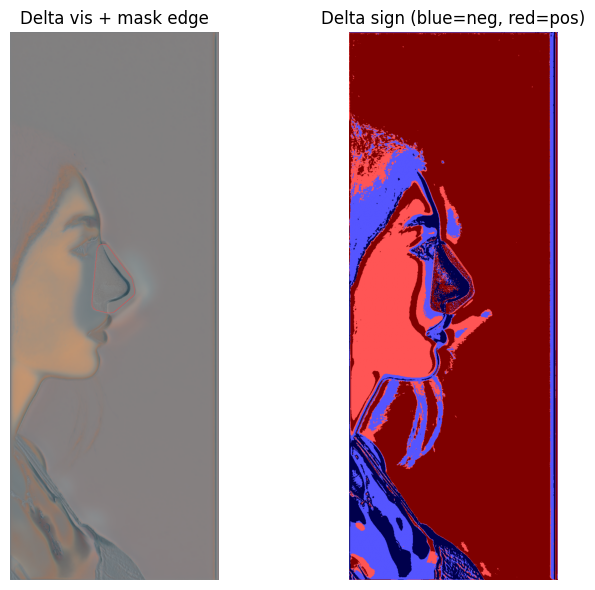

[epoch 71] L1(m)=0.2466 | SSIM(g)=0.8427 | SSIM(m)=0.9935 | LPIPS(m)=0.3032 | best=0.2466 | saved_best=True


train 72/80: 100%|██████████| 257/257 [01:34<00:00,  2.71it/s, D=0.000, G=3.099, L1m=0.1861, OID=0.0000, ADV=4.5742, Perc=0.2710, SSIMm=0.9949, lrG=2.00e-05]


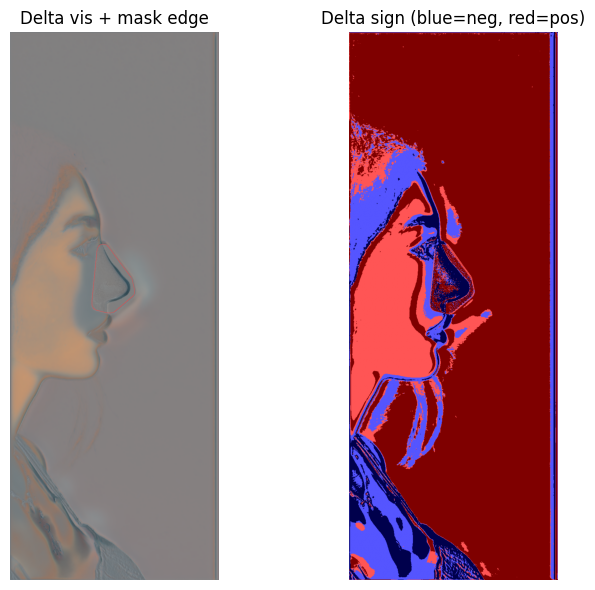

[epoch 72] L1(m)=0.2459 | SSIM(g)=0.8427 | SSIM(m)=0.9935 | LPIPS(m)=0.3023 | best=0.2459 | saved_best=True
[WARN] Extra sample not found: WhatsApp Image 2025-07-12 at 1.31.43 AM (1)
[WARN] Extra sample not found: WhatsApp Image 2025-07-12 at 1.36.06 AM (1)
[WARN] Extra sample not found: WhatsApp Image 2025-07-12 at 1.36.12 AM
[OK] Saved visualization grid → ckpts_Unet_PatchGan_Res_SSIMv1_test_no_clamp_with_new_mask/samples/ep_072.png (extras added: 0)


train 73/80: 100%|██████████| 257/257 [01:33<00:00,  2.74it/s, D=0.000, G=2.153, L1m=0.1123, OID=0.0000, ADV=5.3086, Perc=0.2019, SSIMm=0.9965, lrG=2.00e-05]


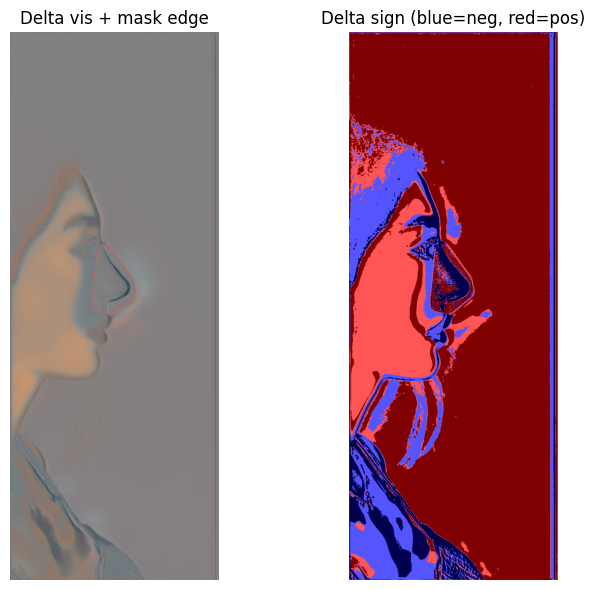

[epoch 73] L1(m)=0.2453 | SSIM(g)=0.8427 | SSIM(m)=0.9935 | LPIPS(m)=0.3015 | best=0.2453 | saved_best=True


train 74/80: 100%|██████████| 257/257 [01:34<00:00,  2.73it/s, D=0.000, G=2.956, L1m=0.1628, OID=0.0000, ADV=5.1562, Perc=0.2822, SSIMm=0.9952, lrG=2.00e-05]


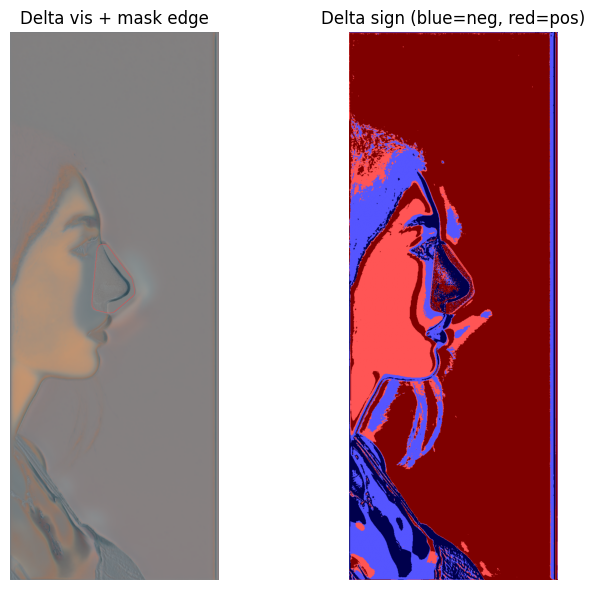

[epoch 74] L1(m)=0.2447 | SSIM(g)=0.8428 | SSIM(m)=0.9935 | LPIPS(m)=0.3009 | best=0.2447 | saved_best=True


train 75/80: 100%|██████████| 257/257 [01:35<00:00,  2.68it/s, D=0.000, G=5.921, L1m=0.4426, OID=0.0000, ADV=4.8086, Perc=0.3621, SSIMm=0.9925, lrG=2.00e-05]


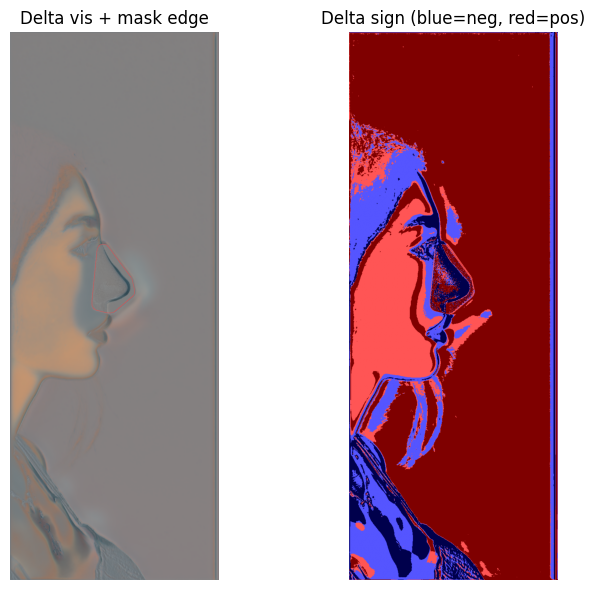

[epoch 75] L1(m)=0.2442 | SSIM(g)=0.8428 | SSIM(m)=0.9935 | LPIPS(m)=0.3003 | best=0.2442 | saved_best=True
[WARN] Extra sample not found: WhatsApp Image 2025-07-12 at 1.31.43 AM (1)
[WARN] Extra sample not found: WhatsApp Image 2025-07-12 at 1.36.06 AM (1)
[WARN] Extra sample not found: WhatsApp Image 2025-07-12 at 1.36.12 AM
[OK] Saved visualization grid → ckpts_Unet_PatchGan_Res_SSIMv1_test_no_clamp_with_new_mask/samples/ep_075.png (extras added: 0)


train 76/80: 100%|██████████| 257/257 [01:34<00:00,  2.72it/s, D=0.000, G=2.199, L1m=0.0993, OID=0.0000, ADV=5.1797, Perc=0.2437, SSIMm=0.9948, lrG=2.00e-05]


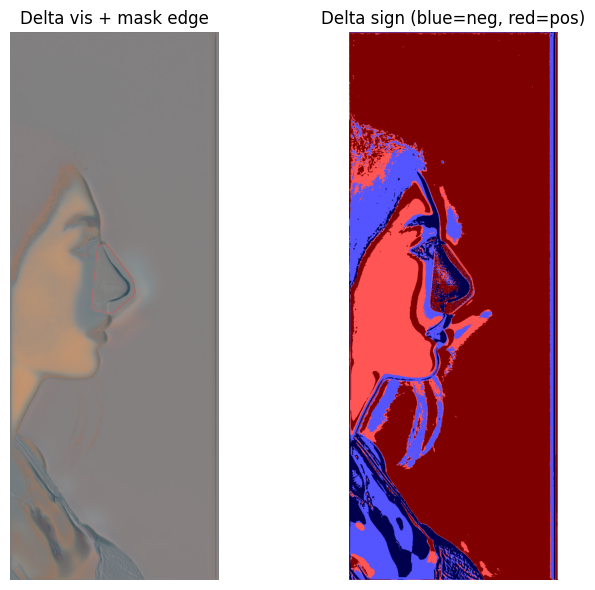

[epoch 76] L1(m)=0.2437 | SSIM(g)=0.8428 | SSIM(m)=0.9935 | LPIPS(m)=0.2997 | best=0.2437 | saved_best=True


train 77/80: 100%|██████████| 257/257 [01:33<00:00,  2.73it/s, D=0.000, G=3.362, L1m=0.2061, OID=0.0000, ADV=5.0352, Perc=0.2812, SSIMm=0.9912, lrG=2.00e-05]


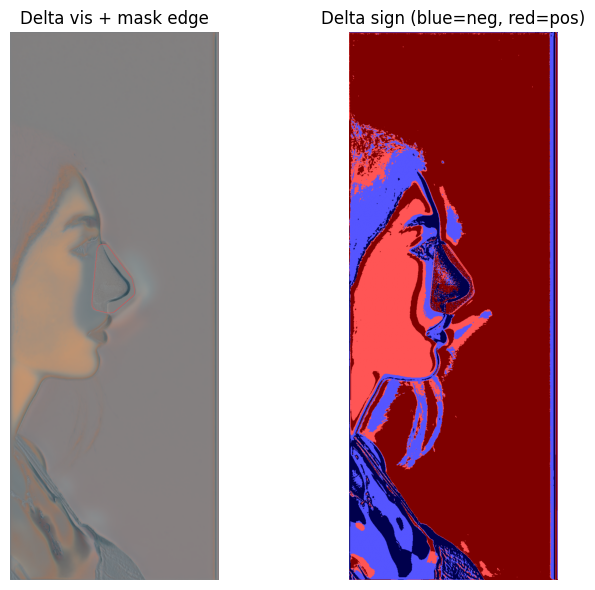

[epoch 77] L1(m)=0.2432 | SSIM(g)=0.8428 | SSIM(m)=0.9935 | LPIPS(m)=0.2992 | best=0.2432 | saved_best=True


train 78/80: 100%|██████████| 257/257 [01:34<00:00,  2.72it/s, D=0.000, G=2.434, L1m=0.1322, OID=0.0000, ADV=5.0898, Perc=0.2250, SSIMm=0.9943, lrG=2.00e-05]


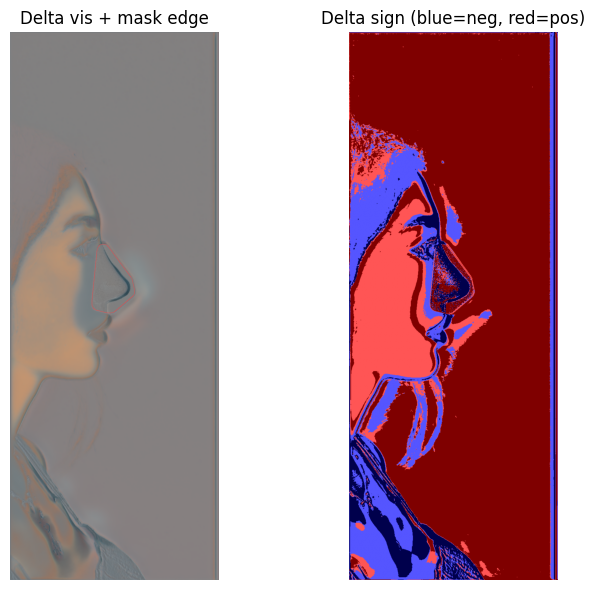

[epoch 78] L1(m)=0.2428 | SSIM(g)=0.8428 | SSIM(m)=0.9935 | LPIPS(m)=0.2987 | best=0.2428 | saved_best=True
[WARN] Extra sample not found: WhatsApp Image 2025-07-12 at 1.31.43 AM (1)
[WARN] Extra sample not found: WhatsApp Image 2025-07-12 at 1.36.06 AM (1)
[WARN] Extra sample not found: WhatsApp Image 2025-07-12 at 1.36.12 AM
[OK] Saved visualization grid → ckpts_Unet_PatchGan_Res_SSIMv1_test_no_clamp_with_new_mask/samples/ep_078.png (extras added: 0)


train 79/80: 100%|██████████| 257/257 [01:34<00:00,  2.72it/s, D=0.000, G=2.274, L1m=0.1124, OID=0.0000, ADV=5.2891, Perc=0.2314, SSIMm=0.9963, lrG=2.00e-05]


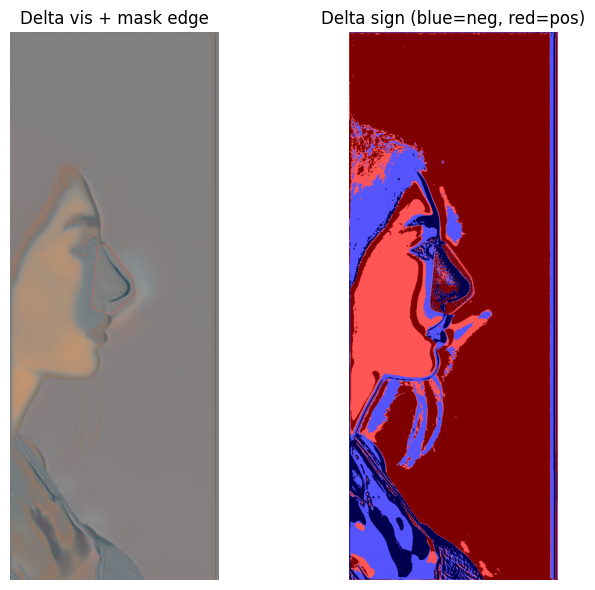

[epoch 79] L1(m)=0.2425 | SSIM(g)=0.8428 | SSIM(m)=0.9935 | LPIPS(m)=0.2982 | best=0.2425 | saved_best=True


train 80/80: 100%|██████████| 257/257 [01:34<00:00,  2.71it/s, D=0.000, G=4.717, L1m=0.3208, OID=0.0000, ADV=4.7344, Perc=0.3491, SSIMm=0.9924, lrG=2.00e-05]


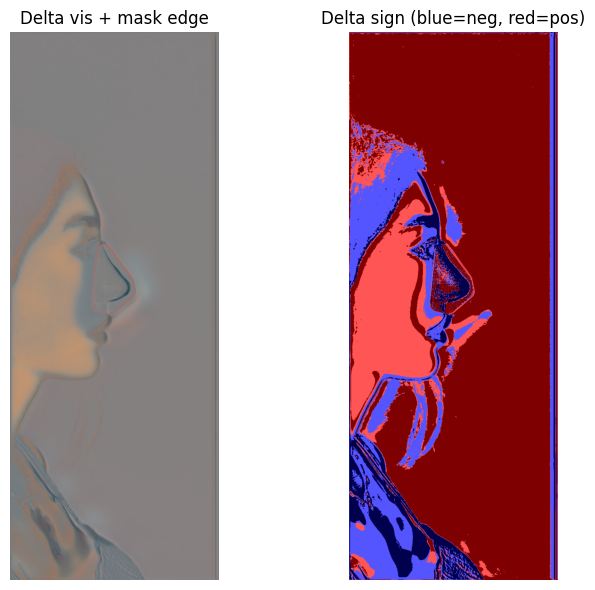

[epoch 80] L1(m)=0.2421 | SSIM(g)=0.8428 | SSIM(m)=0.9935 | LPIPS(m)=0.2978 | best=0.2421 | saved_best=True
Best checkpoint saved at: ckpts_Unet_PatchGan_Res_SSIMv1_test_no_clamp_with_new_mask/best_l1_mask.pt


In [27]:
if __name__ == "__main__":


    
    resume_ckpt = "ckpts_Unet_PatchGan_Res_SSIMv1_test_no_clamp_with_new_mask/last.pt"

    best_path = train_gan(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=80,                              # how many epochs you want
    out_dir="ckpts_Unet_PatchGan_Res_SSIMv1_test_no_clamp_with_new_mask",    # where to save checkpoints
    amp=True,
    device=device,
    resume_from=resume_ckpt,                # pass checkpoint path or None
    lambda_l1=9.5,
    lambda_out_id=0.5,
    use_perc=True,
    perceptual_fn = perceptual_fn,# set True if you pass a perceptual_fn
    use_ssim_loss=True,                     # enable SSIM/MS-SSIM loss
    use_ms_ssim=False,                      # True if you want MS-SSIM instead
    lambda_ssim=0.1                         # weight for SSIM loss
)

print("Best checkpoint saved at:", best_path)

In [13]:
device = "cuda" if torch.cuda.is_available() else "mps"

# path to your trained checkpoint
ckpt_path = "ckpts_Unet_PatchGan_Res_SSIMv1_test_no_clamp_with_new_mask/best_l1_mask.pt" 

# rebuild generator architecture  (same as training)
G = UNetNoseGenerator(in_ch=4, out_ch=3, base=64, depth=5, res_max=0.75).to(device)

# load weights
ckpt = torch.load(ckpt_path, map_location=device)
G.load_state_dict(ckpt["G"])
G.eval()

print("Loaded generator from", ckpt_path)

Loaded generator from ckpts_Unet_PatchGan_Res_SSIMv1_test_no_clamp_with_new_mask/best_l1_mask.pt


## Inference

In [15]:
import os
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision import transforms as T
from PIL import Image
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from lpips import LPIPS

@torch.no_grad()
def _dilate_mask(mask_t: torch.Tensor, dilate_px: int) -> torch.Tensor:
    """Dilate a binary/soft mask [B,1,H,W] by `dilate_px` pixels."""
    if dilate_px <= 0:
        return mask_t
    k = dilate_px * 2 + 1
    return F.max_pool2d(mask_t, kernel_size=k, stride=1, padding=dilate_px)

@torch.no_grad()
def infer_single_with_metrics(
    G,
    img_path: str,
    mask_path: str,
    target_path: str = None,    # optional for metrics
    out_path: str = "output.png",
    dilate_px: int = 0,
    clamp_output: bool = True,
    device: torch.device = None,
):
    """
    Inference on one (image, mask) pair:
      - runs generator
      - dilates mask
      - blends full_rgb and input
      - optionally compares against target using SSIM/LPIPS
    """
    if device is None:
        device = next(G.parameters()).device

    # ---- Load RGB ----
    rgb = Image.open(img_path).convert("RGB")
    rgb_t = T.ToTensor()(rgb).unsqueeze(0).to(device)  # [1,3,H,W]

    # ---- Load mask ----
    mask = Image.open(mask_path).convert("L")
    mask_t = T.ToTensor()(mask).unsqueeze(0).to(device)
    if mask_t.shape[-2:] != rgb_t.shape[-2:]:
        mask_t = F.interpolate(mask_t, size=rgb_t.shape[-2:], mode="nearest")

    # ---- Forward ----
    inp = torch.cat([rgb_t, mask_t], dim=1)
    try:
        out, full_rgb, pred_mask = G(inp, return_full=True)
    except TypeError:
        full_rgb = G(inp)
        pred_mask = mask_t

    # ---- Dilate & blend ----
    mask_d = _dilate_mask(pred_mask, dilate_px).clamp(0, 1)
    blended = rgb_t + mask_d * (full_rgb - rgb_t)
    if clamp_output:
        blended = blended.clamp(0, 1)

    # ---- Save output ----
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    save_image(blended, out_path)
    print(f"[OK] Saved blended output → {out_path}")

    # ---- Metrics ----
    metrics = {}
    if target_path and os.path.exists(target_path):
        target = Image.open(target_path).convert("RGB")
        tgt_t = T.ToTensor()(target).unsqueeze(0).to(device)
        if tgt_t.shape[-2:] != blended.shape[-2:]:
            tgt_t = F.interpolate(tgt_t, size=blended.shape[-2:], mode="bilinear")

        ssim_global = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
        ssim_masked = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
        lpips_fn = LPIPS(net="vgg").to(device)

        ssim_g = ssim_global(blended, tgt_t).item()
        blended_m = blended * mask_t
        tgt_m = tgt_t * mask_t
        ssim_m = ssim_masked(blended_m, tgt_m).item()
        lp = lpips_fn(blended, tgt_t).mean().item()

        metrics = {
            "SSIM_global": ssim_g,
            "SSIM_mask": ssim_m,
            "LPIPS": lp,
        }

        print("\n==== Metrics ====")
        print(f"Global SSIM : {ssim_g:.4f}")
        print(f"Mask   SSIM : {ssim_m:.4f}")
        print(f"LPIPS Score: {lp:.4f}")
        print("=================\n")

    else:
        print("[INFO] Target not provided — metrics skipped.")

    return blended, metrics

In [18]:
iblended, metrics = infer_single_with_metrics(
    G,
    img_path="/workspace/data_splits/train/input/WhatsApp Image 2025-07-12 at 1.06.34 AM.jpeg",
    mask_path="/workspace/data_splits/train/mask_input_new/WhatsApp Image 2025-07-12 at 1.06.34 AM.png",
    target_path="/workspace/data_splits/train/target/WhatsApp Image 2025-07-12 at 1.06.34 AM.jpeg",
    out_path="test_blended_clamped_perc_train.png",
    dilate_px=0,
)

[OK] Saved blended output → test_blended_clamped_perc_train.png
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth

==== Metrics ====
Global SSIM : 0.7026
Mask   SSIM : 0.9943
LPIPS Score: 0.2590



In [48]:
test_ds = NoseFolderDataset(
    "/workspace/data_splits/test/input",
    "/workspace/data_splits/test/mask_input_new",
    "/workspace/data_splits/test/target"
)

test_loader = DataLoader(
    test_ds, batch_size=2, shuffle=False, num_workers=2, pin_memory=True,
    persistent_workers=False,
    collate_fn=lambda b: collate_keep_aspect(b, multiple=32)
)



[validate] counts: img=68 mask=65 target=68
[validate] common triples: 65
[validate] missing masks for 3 imgs, e.g. ['WhatsApp Image 2025-07-12 at 1.36.12 AM (2)', 'WhatsApp Image 2025-07-12 at 5.38.14 PM (1)', 'WhatsApp Image 2025-07-12 at 5.53.22 PM (1)']


In [22]:
G.eval().to(device)

metrics = infer_with_loader(
    G,
    train_loader,
    out_dir="/workspace/train_outputs/outputs",
    grid_dir="/workspace/train_outputs/grids",
    device=device,
    dilate_px=0
)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


[infer]: 100%|██████████| 257/257 [06:37<00:00,  1.55s/it, SSIMg=0.831, SSIMm=0.995, LPIPS=0.179]


==== Test Metrics ====
Global SSIM : 0.8361
Mask   SSIM : 0.9939
LPIPS Score: 0.1734



In [20]:
import os, torch, numpy as np
import torch.nn.functional as F
from torchvision.utils import save_image, make_grid
from torchvision.transforms.functional import to_pil_image
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from lpips import LPIPS
from tqdm import tqdm

@torch.no_grad()
def _dilate_mask(mask_t: torch.Tensor, dilate_px: int) -> torch.Tensor:
    """Dilate [B,1,H,W] mask by `dilate_px` pixels using max-pooling."""
    if dilate_px <= 0:
        return mask_t
    k = dilate_px * 2 + 1
    return F.max_pool2d(mask_t, kernel_size=k, stride=1, padding=dilate_px)

@torch.no_grad()
def infer_with_loader(
    G,
    test_loader,
    out_dir="test_outputs",
    grid_dir="test_outputs/grids",
    device=None,
    dilate_px: int = 0,       # same as infer_single()
    clamp_output: bool = True,
):
    """
    Inference with mask dilation & re-blending:
        blended = rgb + mask_dilated * (full_rgb - rgb)
    Saves predictions, triptych grids, and computes SSIM/LPIPS metrics.
    """
    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(grid_dir, exist_ok=True)

    if device is None:
        device = next(G.parameters()).device

    # ---- Metrics ----
    ssim_global = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    ssim_masked = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    lpips_fn = LPIPS(net="vgg").to(device)

    ssim_g_list, ssim_m_list, lpips_list = [], [], []

    pbar = tqdm(test_loader, desc="[infer]")

    for batch in pbar:
        rgb   = batch["input"].to(device)   # [B,3,H,W]
        tgt   = batch["target"].to(device)  # [B,3,H,W]
        mask  = batch["mask"].to(device)    # [B,1,H,W]
        fnames = batch.get("fname", [f"img_{i}.png" for i in range(rgb.size(0))])

        # ---- Forward pass ----
        inp = torch.cat([rgb, mask], dim=1)
        try:
            out, full_rgb, pred_mask = G(inp, return_full=True)
        except TypeError:
            full_rgb = G(inp)
            pred_mask = mask

        # ---- Mask dilation & blending ----
        mask_d = pred_mask
        blended = rgb + mask_d * (full_rgb - rgb)
        if clamp_output:
            blended = blended.clamp(0, 1)

        # ---- Per-sample metrics, saving, and grids ----
        for b, fname in enumerate(fnames):
            stem = os.path.splitext(fname)[0]
            save_path = os.path.join(out_dir, f"{stem}.png")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            save_image(blended[b], save_path)

            # --- Metrics ---
            ssim_g = ssim_global(blended[b:b+1], tgt[b:b+1]).item()

            blended_m = blended[b:b+1] * mask[b:b+1]
            tgt_m = tgt[b:b+1] * mask[b:b+1]
            ssim_m = ssim_masked(blended_m, tgt_m).item()

            lp = lpips_fn(blended[b:b+1], tgt[b:b+1]).mean().item()

            ssim_g_list.append(ssim_g)
            ssim_m_list.append(ssim_m)
            lpips_list.append(lp)

            # --- Grid: (input | blended | target) ---
            grid = make_grid(
                torch.cat([rgb[b:b+1], blended[b:b+1], tgt[b:b+1]], dim=0),
                nrow=3, padding=4, normalize=True, value_range=(0, 1)
            )
            grid_path = os.path.join(grid_dir, f"{stem}_grid.jpg")
            to_pil_image(grid).save(grid_path, quality=95, subsampling=0)

        # ---- Live metrics summary ----
        pbar.set_postfix({
            "SSIMg": f"{np.mean(ssim_g_list[-5:]):.3f}",
            "SSIMm": f"{np.mean(ssim_m_list[-5:]):.3f}",
            "LPIPS": f"{np.mean(lpips_list[-5:]):.3f}"
        })

    # ---- Summary ----
    ssim_g_mean = float(np.mean(ssim_g_list)) if ssim_g_list else 0.0
    ssim_m_mean = float(np.mean(ssim_m_list)) if ssim_m_list else 0.0
    lpips_mean  = float(np.mean(lpips_list))  if lpips_list  else 0.0

    print("\n==== Test Metrics ====")
    print(f"Global SSIM : {ssim_g_mean:.4f}")
    print(f"Mask   SSIM : {ssim_m_mean:.4f}")
    print(f"LPIPS Score: {lpips_mean:.4f}")
    print("======================\n")

    return {
        "ssim_global": ssim_g_list,
        "ssim_mask": ssim_m_list,
        "lpips": lpips_list,
        "mean": {
            "ssim_global": ssim_g_mean,
            "ssim_mask": ssim_m_mean,
            "lpips": lpips_mean,
        },
    }

### Code to Export a Complete Data set with Predictions , Input , Masks, Target for Train, Val and Test Sets

In [66]:
import os, os.path as osp
from pathlib import Path
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import utils as vutils
from torchvision.utils import make_grid
from tqdm import tqdm

# ---------- utility: ensure dirs ----------
def _ensure_dirs(root):
    for sub in ["pred", "mask", "target", "input", "grids"]:
        os.makedirs(osp.join(root, sub), exist_ok=True)

# ---------- utility: save single image tensor ----------
def _save_tensor_img(t, path):
    """
    t: [C,H,W] in [0,1]; supports 1ch or 3ch
    """
    vutils.save_image(t.clamp(0,1), path)

def _mask_to_rgb(mask_1ch):
    """[1,H,W] -> [3,H,W] red overlay-friendly"""
    if mask_1ch.size(0) == 1:
        return mask_1ch.repeat(3,1,1)
    return mask_1ch

# ---------- main export for one split ----------
@torch.no_grad()
def export_split_for_refiner(G, loader, out_dir_split, *, device="cuda", ext=".png"):
    """
    Writes per-sample files:
      out_dir_split/pred/<basename>.png
      out_dir_split/mask/<basename>.png
      out_dir_split/target/<basename>.png
      out_dir_split/input/<basename>.png
    And per-batch grids:
      out_dir_split/grids/grid_XXXX.png

    Uses 'orig_hw' to crop away padding if present.
    """
    G.eval()
    _ensure_dirs(out_dir_split)

    pbar = tqdm(loader, desc=f"[export] → {Path(out_dir_split).name}")
    for bi, batch in enumerate(pbar):
        rgb    = batch["input"].to(device)      # [B,3,Ht,Wt] in [0,1]
        target = batch.get("target")
        target = target.to(device) if (target is not None) else None
        mask   = batch["mask"].to(device)       # [B,1,Ht,Wt]
        orig_hw = batch.get("orig_hw", None)    # [B,2] (H, W)
        files = batch.get("files", None)        # list of tuples (input_file, mask_file, target_file)

        # build basenames
        if files is not None:
            basenames = [Path(f[0]).stem if f and f[0] else f"sample_{bi:04d}_{i:02d}"
                         for i, f in enumerate(files)]
        elif "fname" in batch:
            basenames = [Path(n).stem for n in batch["fname"]]
        elif "input_file" in batch:
            basenames = [Path(p).stem for p in batch["input_file"]]
        else:
            B = rgb.size(0)
            basenames = [f"sample_{bi:04d}_{i:02d}" for i in range(B)]

        # forward
        inp = torch.cat([rgb, mask], dim=1)
        pred = G(inp)  # assume model outputs [0,1] or close; clamp when saving

        # unpad/crop back to original size per sample if orig_hw is provided
        B = pred.size(0)
        tiles_for_grid = []
        for i in range(B):
            base = basenames[i]

            # slice to per-sample
            pred_i = pred[i].detach()
            mask_i = mask[i].detach()
            rgb_i  = rgb[i].detach()
            tgt_i  = target[i].detach() if target is not None else None

            if orig_hw is not None:
                H, W = int(orig_hw[i,0].item()), int(orig_hw[i,1].item())
                pred_i = pred_i[:, :H, :W]
                mask_i = mask_i[:, :H, :W]
                rgb_i  = rgb_i[:,  :H, :W]
                if tgt_i is not None:
                    tgt_i = tgt_i[:, :H, :W]

            # save per-sample
            _save_tensor_img(pred_i, osp.join(out_dir_split, "pred",   base + ext))
            _save_tensor_img(mask_i, osp.join(out_dir_split, "mask",   base + ext))
            _save_tensor_img(rgb_i,  osp.join(out_dir_split, "input",  base + ext))
            if tgt_i is not None:
                _save_tensor_img(tgt_i, osp.join(out_dir_split, "target", base + ext))

            # collect tiles for grid: Input | Pred | Target? | Mask
            tiles_for_grid.append(rgb_i.clamp(0,1))
            tiles_for_grid.append(pred_i.clamp(0,1))
            if tgt_i is not None:
                tiles_for_grid.append(tgt_i.clamp(0,1))
            # mask as 3ch for consistent grid tile width
            tiles_for_grid.append(_mask_to_rgb(mask_i.clamp(0,1)))

        # make one grid per batch
        try:
            cols = 4 if target is not None else 3  # Input/Pred/Target/Mask or Input/Pred/Mask
            grid = make_grid(tiles_for_grid, nrow=cols, padding=2)
            grid_path = osp.join(out_dir_split, "grids", f"grid_{bi:04d}.png")
            vutils.save_image(grid, grid_path)
        except Exception as e:
            # Fallback: save first few samples separately
            for i in range(min(B, 4)):
                base = basenames[i]
                vutils.save_image(pred[i].clamp(0,1), osp.join(out_dir_split, "grids", f"{base}_pred.png"))

    print(f"✓ Exported split to: {out_dir_split}")

# ---------- convenience wrapper for all splits ----------
@torch.no_grad()
def export_refiner_dataset(G, loaders_dict, out_root, *, device="cuda", ext=".png"):
    """
    loaders_dict: {"train": train_loader, "val": val_loader, "test": test_loader}
    """
    for split, loader in loaders_dict.items():
        out_dir_split = osp.join(out_root, split)
        export_split_for_refiner(G, loader, out_dir_split, device=device, ext=ext)

In [69]:
if __name__ == "__main__":
    import os
    import torch
    from torch.utils.data import DataLoader
    import multiprocessing as mp

    # ---- device selection (cuda -> mps -> cpu) ----
    if torch.cuda.is_available():
        device = "cuda"
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
    print("Device:", device)

    # (Optional) small speed bump
    torch.backends.cudnn.benchmark = (device == "cuda")

    # ---- paths ----
    TRAIN_IMG = "/workspace/data_splits/train/input"
    TRAIN_MSK = "/workspace/data_splits/train/mask_input"
    TRAIN_TGT = "/workspace/data_splits/train/target"

    VAL_IMG   = "/workspace/data_splits/val/input"
    VAL_MSK   = "/workspace/data_splits/val/mask_input"
    VAL_TGT   = "/workspace/data_splits/val/target"

    TEST_IMG  = "/workspace/data_splits/test/input"
    TEST_MSK  = "/workspace/data_splits/test/mask_input"
    TEST_TGT  = "/workspace/data_splits/test/target"

    # ---- rebuild + load generator ----
    ckpt_path = "ckpts_Unet_PatchGan_Res_SSIMv1_test_no_clamp/best_l1_mask.pt"
    G = UNetNoseGenerator(in_ch=4, out_ch=3, base=64, depth=5, res_max=0.75).to(device).eval()

    ckpt = torch.load(ckpt_path, map_location=device)
    G.load_state_dict(ckpt["G"], strict=True)
    print("Loaded generator from", ckpt_path)

    # ---- datasets + loaders ----
    train_ds = NoseFolderDataset(TRAIN_IMG, TRAIN_MSK, TRAIN_TGT)
    val_ds   = NoseFolderDataset(VAL_IMG,   VAL_MSK,   VAL_TGT)
    test_ds  = NoseFolderDataset(TEST_IMG,  TEST_MSK,  TEST_TGT)

    bs = 2
    num_cpu = max(2, mp.cpu_count() // 2)
    workers = min(8, num_cpu)
    pin_mem = (device == "cuda")

    collate = lambda b: collate_keep_aspect(b, multiple=32)  # matches UNet stride

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=False,
                              num_workers=workers, pin_memory=pin_mem,
                              persistent_workers=(workers > 0), collate_fn=collate)
    val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False,
                              num_workers=workers, pin_memory=pin_mem,
                              persistent_workers=(workers > 0), collate_fn=collate)
    test_loader  = DataLoader(test_ds,  batch_size=bs, shuffle=False,
                              num_workers=workers, pin_memory=pin_mem,
                              persistent_workers=(workers > 0), collate_fn=collate)

    # ---- export all splits ----
    out_root = "refiner_dataset_v2"
    export_refiner_dataset(
        G,
        {"train": train_loader, "val": val_loader, "test": test_loader},
        out_root,
        device=device,
        ext=".png"
    )

    print("Done.")

Device: cuda
Loaded generator from ckpts_Unet_PatchGan_Res_SSIMv1_test_no_clamp/best_l1_mask.pt
[validate] counts: img=536 mask=513 target=536
[validate] common triples: 513
[validate] missing masks for 23 imgs, e.g. ['WhatsApp Image 2025-07-12 at 1.09.33 AM (1)', 'WhatsApp Image 2025-07-12 at 1.09.35 AM', 'WhatsApp Image 2025-07-12 at 1.30.13 AM (6)', 'WhatsApp Image 2025-07-12 at 1.33.47 AM (4)', 'WhatsApp Image 2025-07-12 at 1.38.10 AM']
[validate] counts: img=67 mask=63 target=67
[validate] common triples: 63
[validate] missing masks for 4 imgs, e.g. ['WhatsApp Image 2025-07-12 at 5.46.30 PM', 'WhatsApp Image 2025-07-12 at 5.46.31 PM (2)', 'WhatsApp Image 2025-07-12 at 5.53.17 PM (1)', 'WhatsApp Image 2025-07-12 at 6.20.03 PM']
[validate] counts: img=68 mask=65 target=68
[validate] common triples: 65
[validate] missing masks for 3 imgs, e.g. ['WhatsApp Image 2025-07-12 at 1.36.12 AM (2)', 'WhatsApp Image 2025-07-12 at 5.38.14 PM (1)', 'WhatsApp Image 2025-07-12 at 5.53.22 PM (1)']


[export] → train: 100%|██████████| 257/257 [11:48<00:00,  2.76s/it]


✓ Exported split to: refiner_dataset_v2/train


[export] → val: 100%|██████████| 32/32 [01:28<00:00,  2.76s/it]


✓ Exported split to: refiner_dataset_v2/val


[export] → test: 100%|██████████| 33/33 [01:29<00:00,  2.70s/it]

✓ Exported split to: refiner_dataset_v2/test
Done.
